In [1]:
# Inicializar sesión de spark

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Human Activity Recognition - EDA")
    .config("spark.driver.memory", "1g")
    .master("local[4]")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/28 03:13:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Cargar los datos desde txt (csv)

from load import load_accelerometer_data, load_demographic_data

ad = load_accelerometer_data(spark, '/data/WISDM_at_v2.0_raw.txt')
demo = load_demographic_data(spark, '/data/WISDM_at_v2.0_demographics.txt')

In [3]:
# Cantidad de rows y schemas

print("Accelerometer data count: ", ad.count())
print("Accelerometer partitions: ", ad.rdd.getNumPartitions())
ad.printSchema()

print("Demographics data count: ", demo.count())
print("Demographics partitions: ", demo.rdd.getNumPartitions())
demo.printSchema()

Accelerometer data count:  3005411
Accelerometer partitions:  4
root
 |-- userId: integer (nullable = true)
 |-- action: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- z: float (nullable = true)

Demographics data count:  563
Demographics partitions:  1
root
 |-- userId: integer (nullable = true)
 |-- height: float (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- weight: float (nullable = true)
 |-- leg_injury: integer (nullable = true)



In [4]:
# Análisis de nulls. Cuantos nulls hay por cada columna?

from pyspark.sql.functions import count, when, col, isnan, mean

def print_null_columns(df):
    df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

print ("Null values in each column of Accelerometer data: ")
print_null_columns(ad)

print ("Null values in each column of Demographics data: ")
print_null_columns(demo)

Null values in each column of Accelerometer data: 


+------+------+---------+-----+-----+-----+
|userId|action|timestamp|    x|    y|    z|
+------+------+---------+-----+-----+-----+
|     0| 24646|    24646|24646|24646|24646|
+------+------+---------+-----+-----+-----+

Null values in each column of Demographics data: 
+------+------+---+---+------+----------+
|userId|height|sex|age|weight|leg_injury|
+------+------+---+---+------+----------+
|     0|    25| 15| 17|    52|        20|
+------+------+---+---+------+----------+



In [5]:
# Que acciones hay presentes en todo el dataset?

print("Actions present in the Accelerometer data: ", 
" , ".join([a[0] for a in ad.filter(col("action").isNotNull()).select("action").distinct().collect()]))

Actions present in the Accelerometer data:  Sitting , Walking , Standing , Stairs , LyingDown , Jogging


In [6]:
# Cantidad de rows por acción

print("Number of samples per action: ")
actions_count = dict([(a[0], a[1]) for a in ad.groupBy('action').count().orderBy('count', ascending=False).collect()])
for k,v in actions_count.items():
    print(k, v)

Number of samples per action: 


Walking 1255923
Sitting 663706
Jogging 438871
Standing 288873
LyingDown 275967
Stairs 57425
None 24646


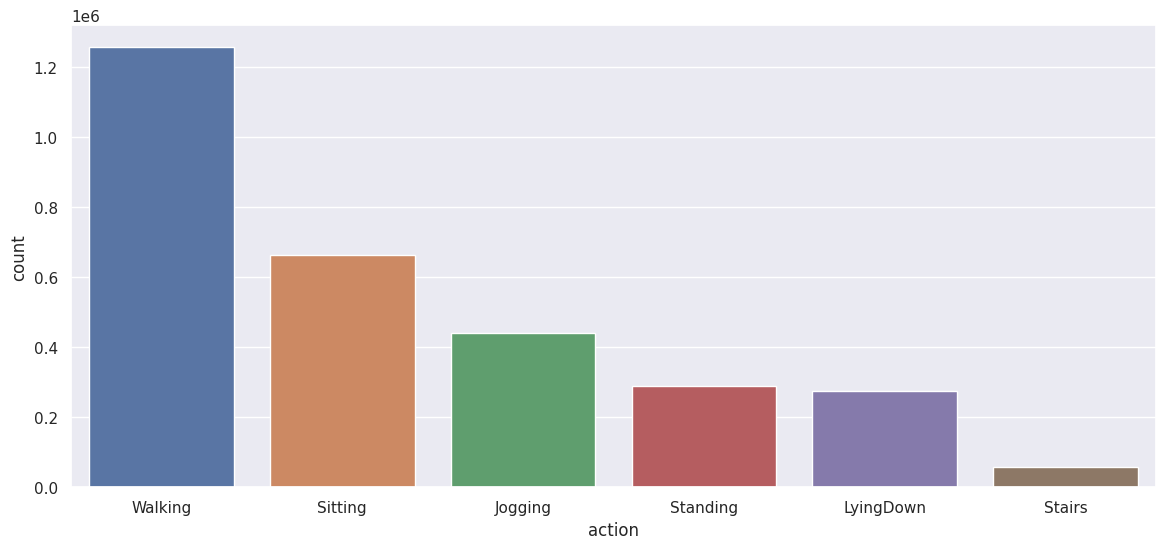

In [7]:
# Grafico la cantidad de rows por acción en un barplot

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
 
plt.figure(figsize=(14,6))
sns.set_theme()
sns.barplot(x = 'action',
            y = 'count',
            data = pd.DataFrame({'action': actions_count.keys(), 'count': actions_count.values()}))

plt.show()

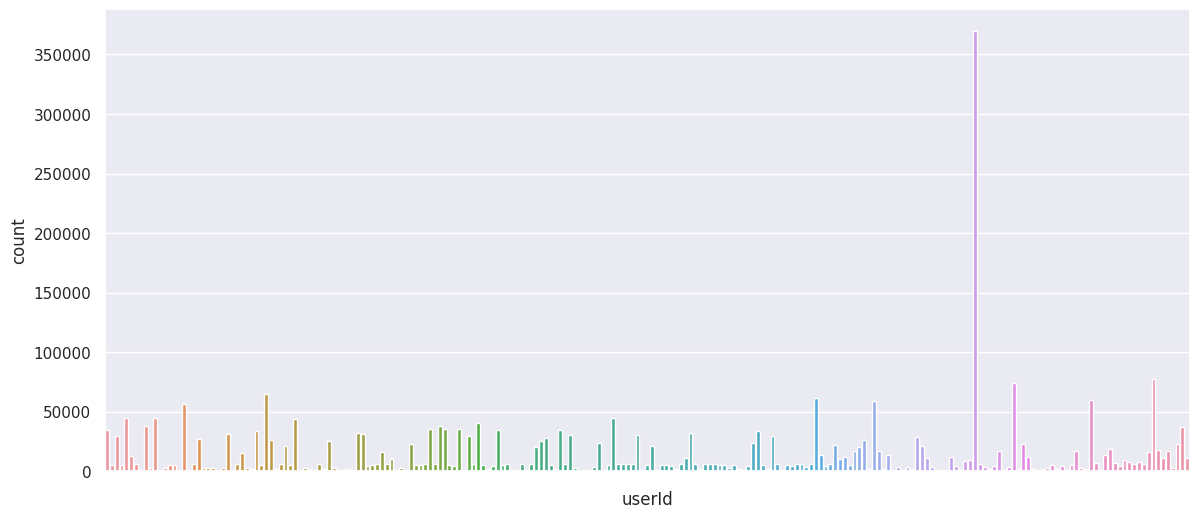

In [8]:
# Cantidad de eventos registrados por usuario
user_count = ad.groupBy('userId').count().orderBy('count', ascending=False).toPandas()

plt.figure(figsize=(14,6))
sns.set_theme()
p = sns.barplot(x = 'userId',
            y = 'count',
            data = user_count)
p.set(xticklabels=[])

plt.show()

In [9]:
# Según la documentación del dataset, las medidas deberían encontrarse entre -20 y 20.
# Veo si hay rows con valores mayores

from pyspark.sql.functions import abs, max, min, lit

rows_outside_bounds = ad.filter((abs(col('x')) > lit(20)) | (abs(col('y')) > lit(20)) | (abs(col('z')) > lit(20))).count()

print("Rows with measures outside boundaries (-20, +20): ", rows_outside_bounds)

print("Maximum absolute values of each axis: ")
ad.select(max(abs(ad.x)).alias('max_abs_x'), max(abs(ad.y)).alias('max_abs_y'), max(abs(ad.z)).alias('max_abs_z')).show()

Rows with measures outside boundaries (-20, +20):  10226
Maximum absolute values of each axis: 


+-------------+------------+------------+
|    max_abs_x|   max_abs_y|   max_abs_z|
+-------------+------------+------------+
|1.44413671E17|4.0947096E11|5.9150805E20|
+-------------+------------+------------+



#### Analizaremos un usuario particular para ver como lucen las distintas acciones en cada sensor:

In [10]:
# Primero busco a aquel usuario con mayor cantidad de acciones y eventos, que voy a utilizar como ejemplo

from pyspark.sql.functions import countDistinct, col, count

user = ad.filter(col('action').isNotNull())\
    .groupby('userId')\
    .agg(countDistinct('action').alias('action'), count('timestamp').alias('timestamp'))\
    .orderBy(col('action').desc(), col('timestamp').desc())\
    .limit(1)\
    .collect()

print("User with most actions and events:", user)

userId = user[0][0]

User with most actions and events: [Row(userId=194, action=6, timestamp=34978)]


In [17]:
# Filtro eventos del usuario 194
user_events = ad.filter((col("userId") == lit(userId)) & (col("action").isNotNull()))
user_events.show()

+------+--------+-------------+-----------+---------+----------+
|userId|  action|    timestamp|          x|        y|         z|
+------+--------+-------------+-----------+---------+----------+
|   194|Standing|1370367549273|-0.38245934|10.473502|-1.6769371|
|   194|Standing|1370367549324|-0.38245934|10.473502|-1.7259704|
|   194|Standing|1370367549374|-0.38245934|10.473502|-1.7651969|
|   194|Standing|1370367549479|-0.38245934|10.473502|-1.8044236|
|   194|Standing|1370367549529|-0.38245934|10.522535|-1.8044236|
|   194|Standing|1370367549589|-0.38245934|10.522535|-1.7553903|
|   194|Standing|1370367549639|-0.38245934|10.522535| -1.706357|
|   194|Standing|1370367549689|-0.42168593|10.522535| -1.706357|
|   194|Standing|1370367549739|-0.42168593|10.473502|-1.8534569|
|   194|Standing|1370367549807|-0.42168593|10.473502|-1.7946169|
|   194|Standing|1370367549857|-0.46091253|10.473502|-1.7946169|
|   194|Standing|1370367550198|-0.40207264|10.473502|-1.7946169|
|   194|Standing|13703675

In [18]:
# Recordamos filtrar valores fuera de +20, -20. Si el valor es mayor a 20 ponemos 20, si es menor a -20, ponemos -20
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

limit = 20

cap_value = udf(lambda x: limit if x > limit else -limit if x < -limit else x, DoubleType())

for c in ['x', 'y', 'z']:
    user_events = user_events.withColumn(c, cap_value(c))

print("Max absolute value of x,y,z sensors after filtering: ")
user_events.select(max(abs(user_events.x)).alias('max_abs_x'), max(abs(user_events.y)).alias('max_abs_y'), max(abs(user_events.z)).alias('max_abs_z')).show()

Max absolute value of x,y,z sensors after filtering: 


+------------------+------------------+------------------+
|         max_abs_x|         max_abs_y|         max_abs_z|
+------------------+------------------+------------------+
|19.966339111328125|19.966339111328125|19.985952377319336|
+------------------+------------------+------------------+



In [19]:
# Necesito agrupar eventos concretos como registros consecutivos de la misma accion

from pyspark.sql.functions import col, lag, sum
from pyspark.sql import Window

w1 = Window.partitionBy("userId").orderBy('timestamp')

user_events = user_events\
    .withColumn("indicator", (col("action") != lag("action").over(w1)).cast("int"))\
    .fillna(0, subset=[ "indicator"])\
    .withColumn("event", sum(col("indicator")).over(w1.rangeBetween(Window.unboundedPreceding, 0)))\
    .drop(col("indicator"))

#### Grafico sensores x,y,z para cada tipo de acción:

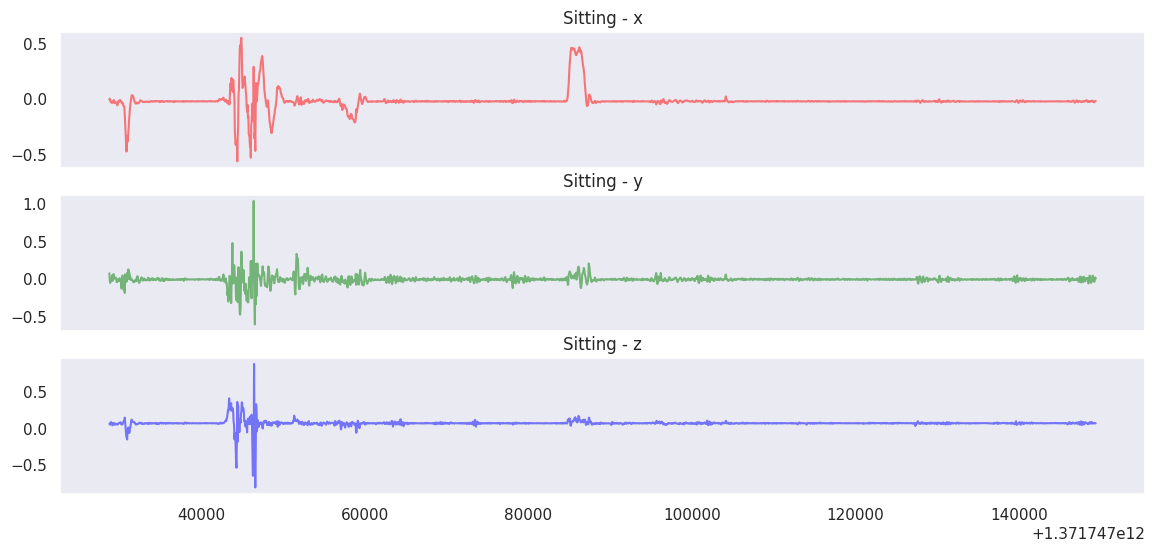

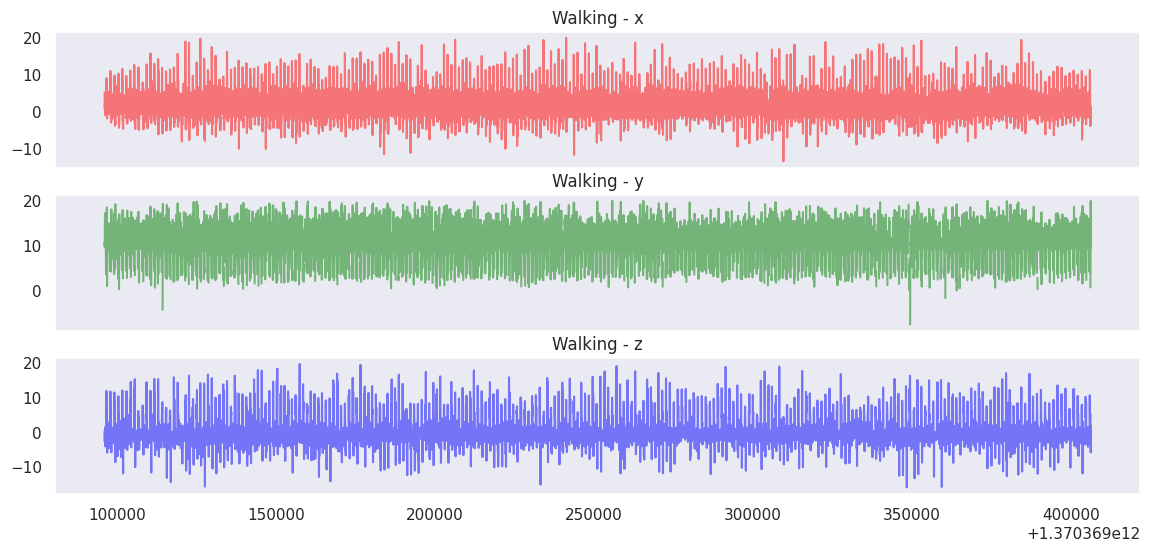

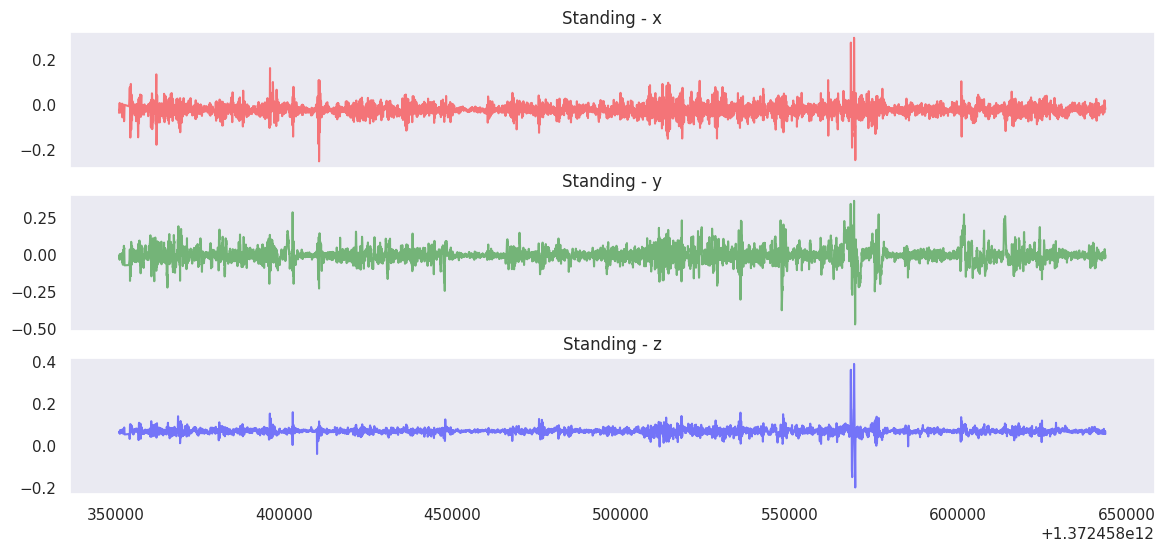

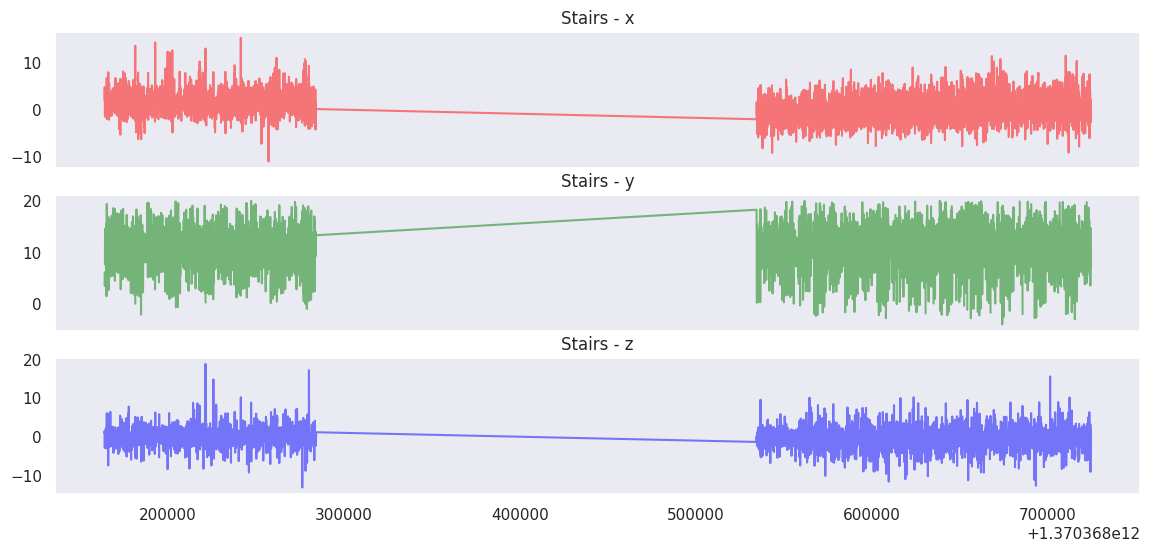

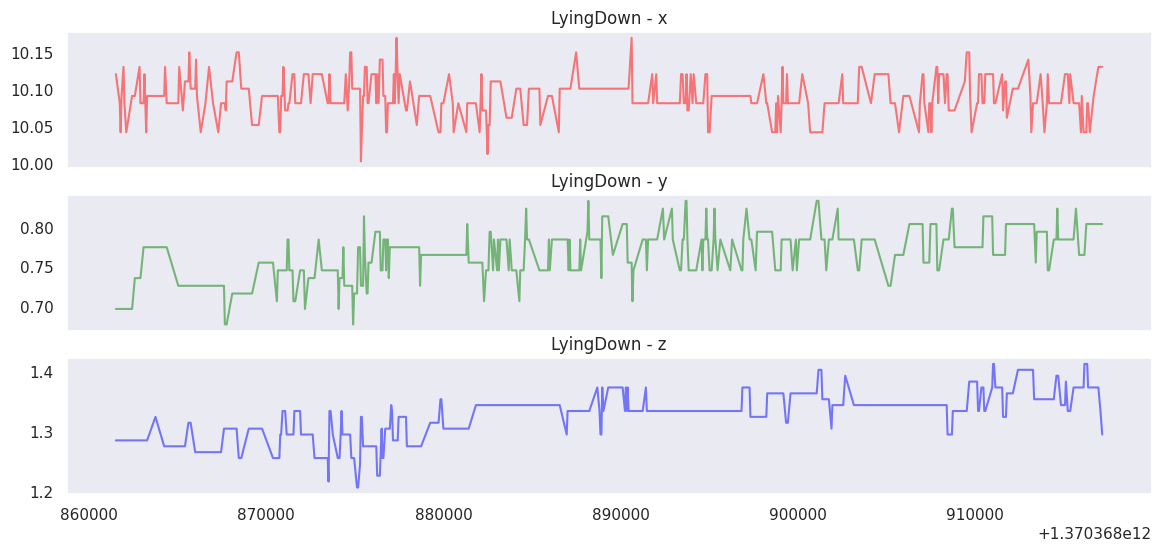

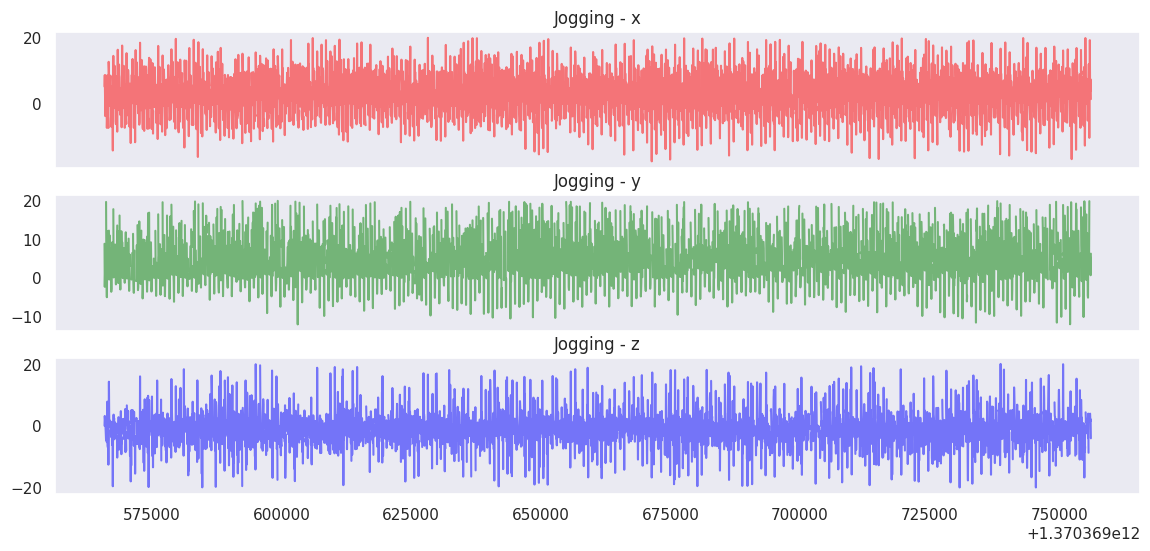

In [21]:
# La idea de ésta funcion plot_xyz fue tomada de:
# https://www.kaggle.com/code/docxian/human-activity-recognition-visual-exploration

def plot_xyz(df, userId, action):   
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,6), sharex=True)
    
    ax1.plot(df['timestamp'], df['x'], color='red', alpha=0.5)
    ax1.set_title(action + ' - x')
    ax1.grid()
    
    ax2.plot(df['timestamp'], df['y'], color='green', alpha=0.5)
    ax2.set_title(action + ' - y')
    ax2.grid()

    ax3.plot(df['timestamp'], df['z'], color='blue', alpha=0.5)
    ax3.set_title(action + ' - z')
    ax3.grid()
    
    plt.show()


for action in [a[0] for a in user_events.select("action").distinct().collect()]:
    # Tomo el evento con mas rows consecutivas de cada accion
    event = user_events.filter(col("action") == lit(action))\
    .groupby('event')\
    .count()\
    .orderBy(col('count').desc())\
    .limit(1)\
    .collect()[0][0]
   
    # Ploteo solo un evento por cada acción
    df = user_events.filter((col("action") == lit(action)) & (col("event") == lit(event))).toPandas()
    plot_xyz(df, userId, action)

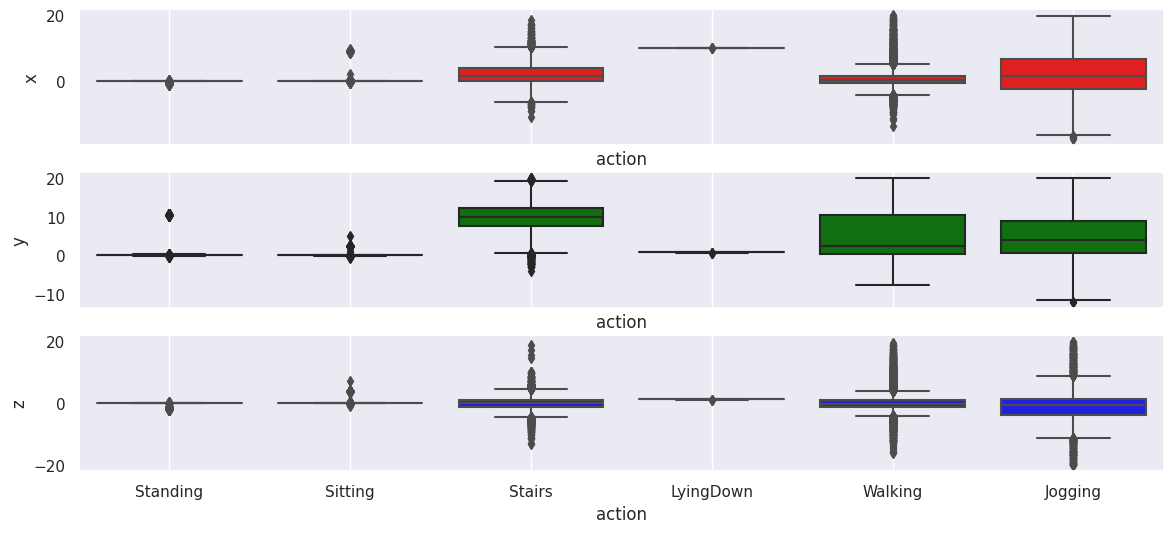

In [29]:
# Realizo ahora un box plot por cada eje, por cada acción. Me va a permitir determinar la media y cuartiles en cada caso.

def box_plot_xyz(df, userId, action):   
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,6), sharex=True)
    
    sns.set_theme()
    sns.boxplot(x = 'action',
            y = 'x',
            ax =ax1,
            color = 'red',
            data = df)
    ax1.grid()
    
    sns.boxplot(x = 'action',
            y = 'y',
            ax =ax2,
            color = 'green',
            data = df)
    ax2.grid()
    
    sns.boxplot(x = 'action',
            y = 'z',
            ax =ax3,
            color = 'blue',
            data = df)
    ax3.grid()
    
    plt.show()

box_plot_xyz(user_events.toPandas(), userId, action)

#### Analizamos el matcheo entre usuarios de data demográfica y usuarios con lectura de sensores:

In [23]:
# Join de ambas tablas por user id. 'fullouter' join permite ver cuantas rows de cada tabla no matchean con la otra.
ad_2 = ad.dropna(how="any")
demo_2 = demo.dropna(how="any")
joined = ad_2.join(demo_2, ad_2.userId == demo_2.userId, 'fullouter').drop(demo_2.userId)

# Chequear cantidad de nulls por columna (son las pertenecientes a filas que no matchearon con la otra tabla)
print_null_columns(joined)

+------+------+---------+---+---+---+-------+-------+-------+-------+----------+
|userId|action|timestamp|  x|  y|  z| height|    sex|    age| weight|leg_injury|
+------+------+---------+---+---+---+-------+-------+-------+-------+----------+
|   449|   449|      449|449|449|449|2149304|2149304|2149304|2149304|   2149304|
+------+------+---------+---+---+---+-------+-------+-------+-------+----------+



In [24]:
print("Count of accelerometer data: ", ad_2.count())
print("Count of demographic data: ", demo_2.count())
print("Count of inner join: ", ad_2.join(demo_2, ad_2.userId == demo_2.userId, "inner").count())

Count of accelerometer data:  2980765
Count of demographic data:  491


Count of inner join:  1741731


Hay muchas rows de accelerometer data que no matchean con la data demográfica, y por ende decido no utilizar ésta última.

#### Análisis para división en training/testing. Cuál es el punto de corte óptimo?

In [25]:
# Primero vemos cual es el min vs max user Id
from pyspark.sql.functions import max,min,col

min_max_userId = ad.select(min(col("userId")).alias("min_userId"), max(col("userId")).alias("max_userId")).collect()
print("Min:", min_max_userId[0][0], "Max:", min_max_userId[0][1])

Min: 194 Max: 1802


In [26]:
# Ahora exploramos distintos puntos de corte y que proporción de rows deja cada uno
min_uid = min_max_userId[0][0]
max_uid = min_max_userId[0][1]
range_uid = (max_uid - min_uid)
start = int(range_uid * 0.7) + min_uid
end = int(range_uid * 0.9) + min_uid
step = (end - start) // 10

for i in range(start, end, step):
    train_count = ad.filter(col("userId") <= i).count()
    test_count = ad.filter(col("userId") > i).count()
    total_count = train_count + test_count
    print("User Id thershold:", i, "Training proportion: ", round(train_count / total_count, 2), "Testing proportion: ", round(test_count / total_count, 2))


User Id thershold: 1319 Training proportion:  0.67 Testing proportion:  0.33


User Id thershold: 1351 Training proportion:  0.67 Testing proportion:  0.33


User Id thershold: 1383 Training proportion:  0.67 Testing proportion:  0.33


User Id thershold: 1415 Training proportion:  0.67 Testing proportion:  0.33


User Id thershold: 1447 Training proportion:  0.67 Testing proportion:  0.33


User Id thershold: 1479 Training proportion:  0.68 Testing proportion:  0.32


User Id thershold: 1511 Training proportion:  0.68 Testing proportion:  0.32


User Id thershold: 1543 Training proportion:  0.69 Testing proportion:  0.31


User Id thershold: 1575 Training proportion:  0.69 Testing proportion:  0.31


User Id thershold: 1607 Training proportion:  0.81 Testing proportion:  0.19


User Id thershold: 1639 Training proportion:  0.82 Testing proportion:  0.18


Elijo entonces 1607 como user threshold para que me quede 80% de training y 20% de testing